In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

d:\Data Science\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Generate Synthetic Marketing Dataset
np.random.seed(42)
n_samples = 2000
data = pd.DataFrame({
    'Age': np.random.randint(18, 70, n_samples),
    'Income': np.random.randint(20000, 120000, n_samples),
    'Marital_Status': np.random.choice(['Single', 'Married', 'Divorced'], n_samples),
    'Website_Visits': np.random.randint(1, 50, n_samples),
    'Previous_Campaigns': np.random.randint(0, 5, n_samples),
    'Total_Spent': np.random.randint(100, 5000, n_samples)
})

In [3]:
data.head()

,Age,Income,Marital_Status,Website_Visits,Previous_Campaigns,Total_Spent
0,56,81788,Divorced,8,1,2904
1,69,102879,Single,24,4,1643
2,46,58827,Divorced,15,1,1789
3,32,25655,Married,43,2,1671
4,60,64859,Divorced,31,1,4641


In [4]:
# Step 2: Split data into features and target
X = data.drop('Total_Spent', axis=1)
y = data['Total_Spent']

In [5]:
# Step 3: Preprocessing
# Define column transformer for scaling and encoding
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['Age', 'Income', 'Website_Visits', 'Previous_Campaigns']),
    ('cat', OneHotEncoder(), ['Marital_Status'])
])

# Apply transformations
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [6]:
# Step 4: Build a DNN Model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)  # Regression output
])
model.compile(optimizer='adam', loss='mse', metrics=['root_mean_squared_error'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

# Model summary
print(model.summary())

# Predictions
y_pred = model.predict(X_test)

d:\Data Science\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,101 (141.02 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,068 (94.02 KB)

None
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [7]:
# Model Evaluation

root_mean_squared_error(y_test,y_pred)

1459.1262364285437

In [8]:
# Step 5: LIME Explanation
explainer_lime = LimeTabularExplainer(X_train, feature_names=feature_names, mode='regression')
sample_idx = 1
lime_exp = explainer_lime.explain_instance(X_test[sample_idx], model.predict)
lime_exp.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


 10%|█         | 1/10 [00:00<00:04,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


 20%|██        | 2/10 [00:01<00:03,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 30%|███       | 3/10 [00:02<00:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 40%|████      | 4/10 [00:03<00:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 50%|█████     | 5/10 [00:04<00:05,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 60%|██████    | 6/10 [00:05<00:04,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|███████   | 7/10 [00:06<00:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 80%|████████  | 8/10 [00:08<00:02,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 90%|█████████ | 9/10 [00:09<00:01,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


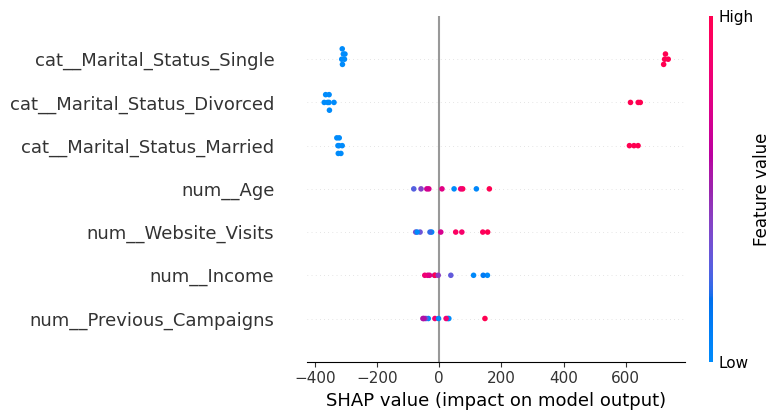

In [9]:
# Step 6: SHAP Explanation
explainer_shap = shap.KernelExplainer(model.predict, X_train[:100])
shap_values = explainer_shap.shap_values(X_test[:10])
shap_values_squeezed = np.squeeze(shap_values, axis=-1)

# SHAP Summary Plot
shap.summary_plot(shap_values_squeezed, X_test[:10], feature_names=feature_names)

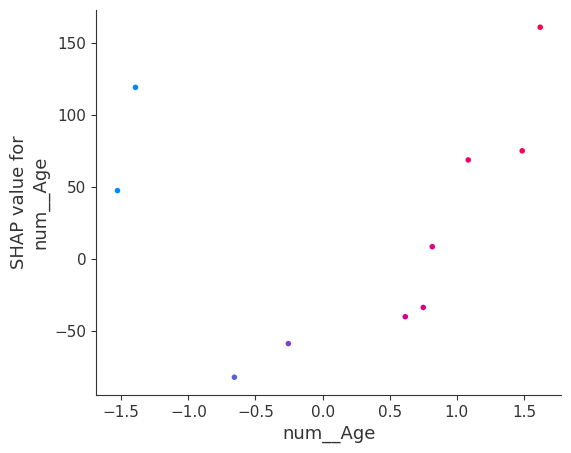

In [10]:
# SHAP Dependence Plot
shap.dependence_plot(0, shap_values_squeezed, X_test[:10], feature_names=feature_names)

In [11]:
y_pred

array([[2592.0056],
       [2562.5344],
       [2673.0374],
       [2557.619 ],
       [2466.7463],
       [2703.5854],
       [2853.728 ],
       [2826.9146],
       [2448.6064],
       [2728.8745],
       [2454.4578],
       [2528.8955],
       [2764.7483],
       [2454.0818],
       [2537.1729],
       [2590.4902],
       [2348.4736],
       [2723.9355],
       [2409.4229],
       [2575.0378],
       [2493.927 ],
       [2391.5942],
       [2401.219 ],
       [2891.8438],
       [2440.4521],
       [2522.0107],
       [2385.2388],
       [2433.3706],
       [2525.6694],
       [2306.2441],
       [2873.9346],
       [2545.9543],
       [2908.084 ],
       [2509.3054],
       [2719.7754],
       [2335.984 ],
       [2558.2527],
       [2528.5881],
       [2748.8623],
       [2559.1426],
       [2627.7617],
       [2459.6213],
       [2824.1672],
       [2478.0945],
       [2478.5513],
       [2412.6006],
       [2432.0415],
       [2449.7537],
       [2581.8152],
       [2521.1477],


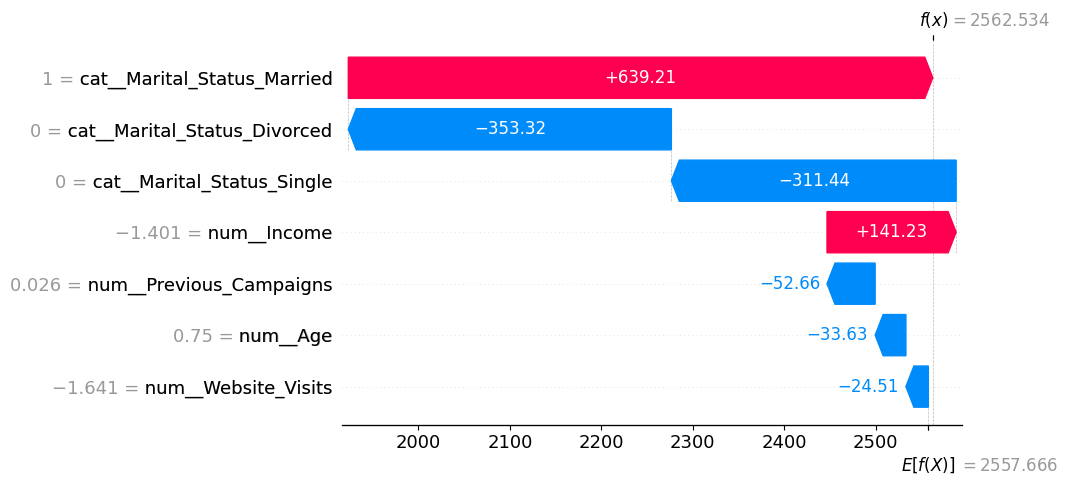

In [12]:
# SHAP Waterfall Plot for a single prediction
sample_index = 1
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_squeezed[sample_index],
        base_values=explainer_shap.expected_value,
        data=X_test[sample_index],
        feature_names=feature_names
    )
)

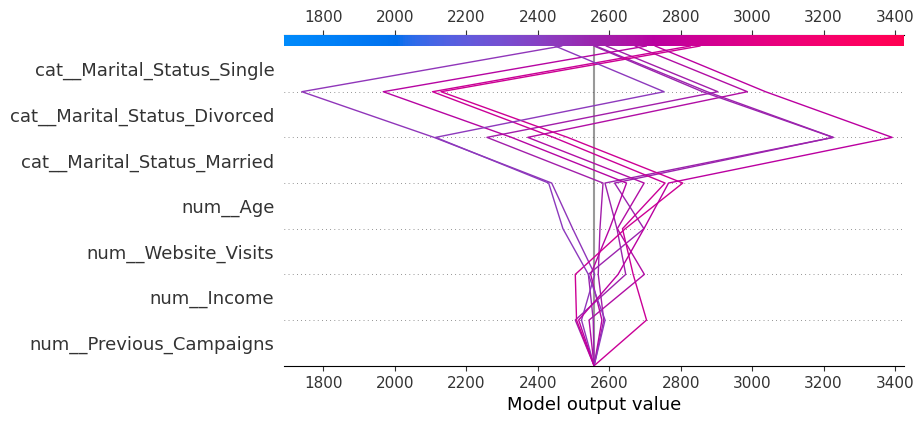

In [13]:
# Generate SHAP Decision Plot
shap.decision_plot(
    explainer_shap.expected_value,
    shap_values_squeezed,
    X_test[:10],
    feature_names=feature_names
)